# Character-Digit level

In [1]:
pip install tensorflow tensorflow-datasets matplotlib

In [11]:
# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import seaborn as sns
import random
import collections

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/balanced/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Balanced
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/root/tensorflow_datasets/emnist/balanced/3.1.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=56.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=47),
    }),
    supervised_k

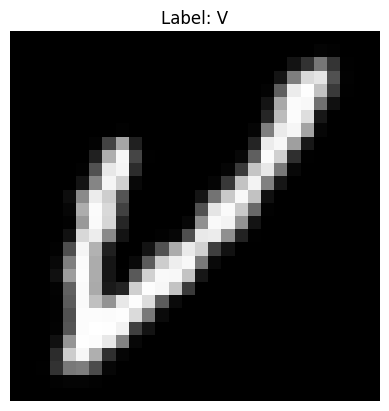

In [3]:
# Load dataset EMNIST - balanced
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,  # (image, label)
    with_info=True
)

# Dataset info
print(ds_info)

# Create label map
def load_emnist_label_map(path="emnist-balanced-mapping.txt"):
    label_dict = {}
    with open(path, 'r') as f:
        for line in f:
            label_index, unicode_val = line.strip().split()
            label_dict[int(label_index)] = chr(int(unicode_val))
    return label_dict

label_map = load_emnist_label_map()

# Display first image and label (with proper orientation)
for image, label in ds_train.take(1):
    # Rotate and flip image
    image = tf.image.rot90(image, k=3)
    image = tf.image.flip_left_right(image)

    label_index = label.numpy()
    label_char = label_map[label_index]

    print("Label index:", label_index)
    print("Label char:", label_char)

    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title(f"Label: {label_char}")
    plt.axis("off")
    plt.show()


In [4]:
# Preprocessing data
def preprocess(image, label):
  # Rotate and flip image
  image = tf.image.rot90(image, k=3)
  image = tf.image.flip_left_right(image)
  # Normalize pixel
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

# Apply preprocess function
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128

ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache().shuffle(10000).batch(batch_size).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(batch_size).cache().prefetch(AUTOTUNE)

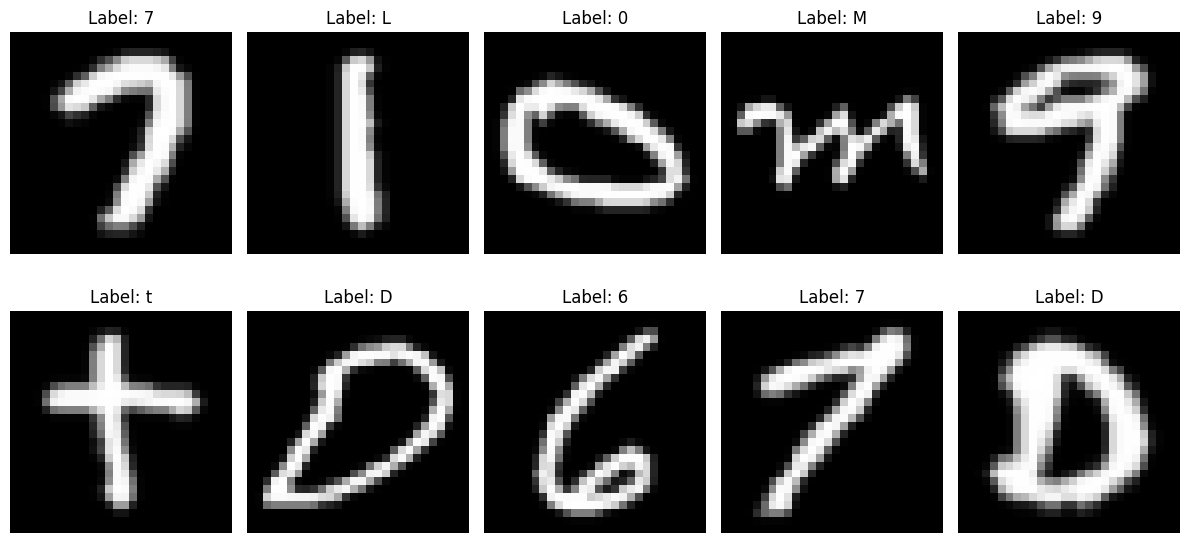

In [5]:
# Display images
for images, labels in ds_train.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {label_map[labels[i].numpy()]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [6]:
# Model CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(ds_info.features['label'].num_classes, activation='softmax')  # Softmax cho classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,807 (897.68 KB)

 Trainable params: 229,807 (897.68 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train model
epochs = 10
history = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test
)

Epoch 1/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.4762 - loss: 1.8814 - val_accuracy: 0.8288 - val_loss: 0.5309
Epoch 2/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7702 - loss: 0.7136 - val_accuracy: 0.8453 - val_loss: 0.4566
Epoch 3/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8046 - loss: 0.5974 - val_accuracy: 0.8584 - val_loss: 0.4172
Epoch 4/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8189 - loss: 0.5460 - val_accuracy: 0.8625 - val_loss: 0.3998
Epoch 5/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8318 - loss: 0.5023 - val_accuracy: 0.8692 - val_loss: 0.3801
Epoch 6/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8392 - loss: 0.4726 - val_accuracy: 0.8698 - val_loss: 0.3779
Epoch 7/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8464 - loss: 0.4459 - val_accuracy: 0.8720 - val_loss: 0.3695
Epoch 8/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8512 - loss: 0.4295 - val_accuracy: 

In [8]:
# Evaluate
test_loss, test_acc = model.evaluate(ds_test)
print("Accuracy on test set:", test_acc)

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3453
Accuracy on test set: 0.8794149160385132


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  


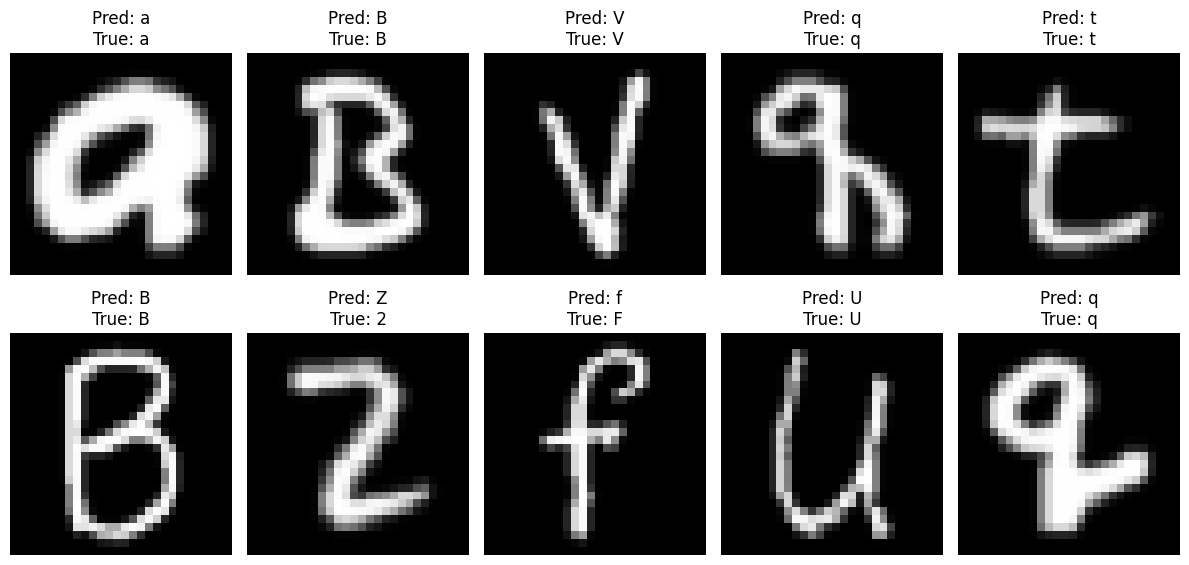

In [9]:
for images, labels in ds_test.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 6))
    for i in range(10):

        image = images[i]
        true_label = labels[i].numpy()
        pred_label = predicted_labels[i]


        tf.image.rot90(image, k=3)
        # image = tf.image.flip_left_right(image)


        true_char = label_map[true_label]
        pred_char = label_map[pred_label]


        plt.subplot(2, 5, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"Pred: {pred_char}\nTrue: {true_char}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [12]:
# Count mistake per class
error_counts = collections.Counter()
total_counts = collections.Counter()

# Get the number of mistake in test set
for images, labels in ds_test:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = labels.numpy()

    for true, pred in zip(true_labels, predicted_labels):
        total_counts[true] += 1
        if true != pred:
            error_counts[true] += 1

# Error rate by class
error_rates = {}
for label_idx in total_counts:
    total = total_counts[label_idx]
    errors = error_counts[label_idx]
    error_rate = errors / total if total > 0 else 0
    error_rates[label_idx] = error_rate

# Sort descending
sorted_errors = sorted(error_rates.items(), key=lambda x: x[1], reverse=True)

# Display top 5
print("Top 5 character/digits with highest error rate:")
for idx, rate in sorted_errors[:5]:
    char = label_map.get(idx, '?')
    print(f"Label: {idx} - Char: '{char}' - Error Rate: {rate:.2%}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━

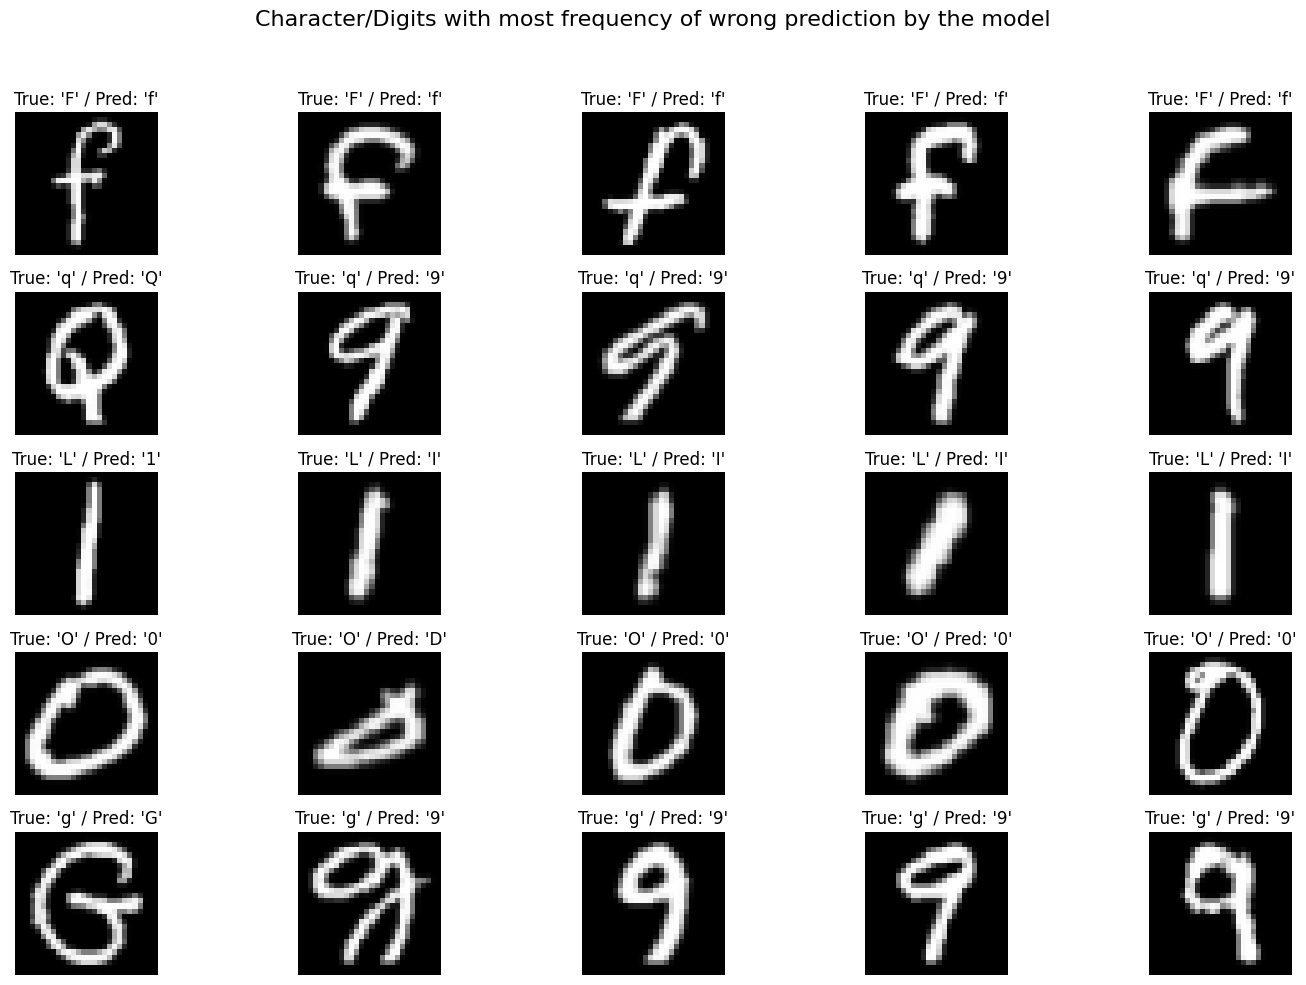

In [13]:
# Number of misslabel class to display
num_labels_to_show = 5
top_wrong_labels = [idx for idx, _ in sorted_errors[:num_labels_to_show]]

# Number of image per label
images_per_label = 5

# Dictionary with wrong examples
wrong_examples = {label: [] for label in top_wrong_labels}

# Get wrong prediction
for images, labels in ds_test:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = labels.numpy()

    for img, true, pred in zip(images, true_labels, predicted_labels):
        if true != pred and true in top_wrong_labels:
            if len(wrong_examples[true]) < images_per_label:
                wrong_examples[true].append((img.numpy().squeeze(), pred))

# Display
fig, axs = plt.subplots(num_labels_to_show, images_per_label, figsize=(15, 10))
fig.suptitle("Character/Digits with most frequency of wrong prediction by the model", fontsize=16)

for row, true_label in enumerate(top_wrong_labels):
    for col in range(images_per_label):
        ax = axs[row, col]
        if col < len(wrong_examples[true_label]):
            img, pred_label = wrong_examples[true_label][col]
            ax.imshow(img, cmap='gray')
            true_char = label_map.get(true_label, '?')
            pred_char = label_map.get(pred_label, '?')
            ax.set_title(f"True: '{true_char}' / Pred: '{pred_char}'")
        ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
